# Movie poster genre classification
----

Source: https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/

What you can learn from this notebook:
* A multilabel image classification, because each movie can have more than one genre's.
* How to use Keras' `ImageDataGenerator` class and `flow_from_dataframe` method to generate and pre-process image data on-the-fly directly for training.

In [1]:
# boilerplate codes
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd
import imageio
import os
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# check the tensorflow version
print("We're using TensorFlow ver. {}".format(tf.__version__))

We're using TensorFlow ver. 1.14.0


In [2]:
# the data folder -- (modify this)
Multi_Label_dataset = r'../../multi-label-clf/movie-poster/Multi_Label_dataset'

# some constant we use later
# (you can change these constant values to experiment)
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)
TEST_FRACTION = 0.1
VALIDATION_FRACTION = 0.1
EPOCHS = 10

## Exploring the data

The data is provided from [this link](https://drive.google.com/file/d/1iQV5kKF_KGZL9ALx9MMXk_Lg7PklBLCE/view?usp=sharing). Assume that you have downloaded it and extracted the zip file to a folder called `Multi_Label_dataset`.

This folder contains:
* `train.csv` file
* `Images` folder

In [3]:
df = pd.read_csv(os.path.join(Multi_Label_dataset, 'train.csv'))
print('Size of the data: {}'.format(df.shape))
df.head()

Size of the data: (7254, 27)


,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Couple things we need to modify the dataframe above before using it in the `ImageDataGenerator` class:
1. The column `Id` contains the image filename without the extension of jpg, so we need to add it to them.
2. The column `Genre` is what we need for the labels, but their values are in string, not list.
3. We can drop all other columns, because the `ImageDataGenerator` will create a one-hot vector automatically for us using the `Genre` values.

In [4]:
# select only Id and Genre, drop other columns
prep_data = df.loc[:, ['Id', 'Genre']]

# append '.jpg' suffix to the Id values
prep_data['Id'] = prep_data['Id'].apply(lambda x: '{}.jpg'.format(x))

# make Genre values as list
prep_data['Genre'] = prep_data['Genre'].apply(lambda x: eval(x))

prep_data.head()

,Id,Genre
0,tt0086425.jpg,"[Comedy, Drama]"
1,tt0085549.jpg,"[Drama, Romance, Music]"
2,tt0086465.jpg,[Comedy]
3,tt0086567.jpg,"[Sci-Fi, Thriller]"
4,tt0086034.jpg,"[Action, Adventure, Thriller]"


In [5]:
# Calculate the number of classes
classes = set()
for g in prep_data['Genre']:
    classes.update(g)
print("We've got {} genre's in the dataset".format(len(classes)))

We've got 25 genre's in the dataset


That's all we need to prepare a dataframe for the `ImageDataGenerator`.

## Build the network model

This is a simple convolutional neural network layers for classification. The only important difference is that the output layer uses **`sigmoid`** activation function to allow independent probability estimation.

In [6]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(5,5), activation="relu", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=32, kernel_size=(5,5), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(5,5), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(5,5), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation="relu"),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    Dropout(0.5),
    
    # IMPORTANT: sigmoid function for multilabel classification
    Dense(len(classes), activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

## Split the data table into training and test

We first need to split the data into **training** and **test** data, and set aside the test data, because the `ImageDataGenerator` can only split the data only for training and validation.

In [7]:
# We're going to just make a simple random split from the indices.
idx = list(prep_data.index)
np.random.shuffle(idx)
ntest = np.int(np.ceil(TEST_FRACTION * len(idx)))
print("For {} rows, we randomly split into {} training and {} test".format(
    len(idx), len(idx[ntest:]), len(idx[0:ntest])))

For 7254 rows, we randomly split into 6528 training and 726 test


In [8]:
# train data
train_data = prep_data.iloc[idx[ntest:],:]

# test data
test_data = prep_data.iloc[idx[0:ntest],:]

print("train_data: {} rows, test_data: {} rows".format(train_data.shape[0], test_data.shape[0]))

# Sanity check
print("Index intersection between train_data and test_data: {}".format(
    set(train_data.index).intersection(set(test_data.index))))

train_data: 6528 rows, test_data: 726 rows
Index intersection between train_data and test_data: set()


## Build the ImageDataGenerator

In [9]:
# Create the ImageDataGenerator
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0,
    validation_split=VALIDATION_FRACTION
)

# Create the training generator
train_gen = image_gen.flow_from_dataframe(
    train_data,
    x_col='Id',
    y_col='Genre',
    directory=os.path.join(Multi_Label_dataset, 'Images'),
    class_mode='categorical',
    subset='training',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

# Create the validation generator
val_gen = image_gen.flow_from_dataframe(
    train_data,
    x_col='Id',
    y_col='Genre',
    directory=os.path.join(Multi_Label_dataset, 'Images'),
    class_mode='categorical',
    subset='validation',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

Found 5876 validated image filenames belonging to 25 classes.
Found 652 validated image filenames belonging to 25 classes.


Look how easy it is!! 

A couple of important things: 
* We pass the image file name to the `x_col` argument.
* We don't need to create a one-hot vector. We just pass the list of label values as the target to the `y_col` argument.
* We set `target_size`. The generator will automatically crop or pad the image if its size is not exactly the same as `IMAGE_SIZE`.
* Notice how we can filter the image by rescaling its values by 1/255, which is normalizing the image.

## Training

In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [11]:
hist = model.fit_generator(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)

Epoch 1/10
92/92 [==============================] - 28s 300ms/step - loss: 0.3954 - acc: 0.8310 - val_loss: 0.2718 - val_acc: 0.9071
Epoch 2/10
92/92 [==============================] - 24s 260ms/step - loss: 0.2859 - acc: 0.9009 - val_loss: 0.2484 - val_acc: 0.9071
Epoch 3/10
92/92 [==============================] - 24s 258ms/step - loss: 0.2707 - acc: 0.9042 - val_loss: 0.2464 - val_acc: 0.9074
Epoch 4/10
92/92 [==============================] - 24s 263ms/step - loss: 0.2649 - acc: 0.9060 - val_loss: 0.2474 - val_acc: 0.9074
Epoch 5/10
92/92 [==============================] - 24s 259ms/step - loss: 0.2598 - acc: 0.9064 - val_loss: 0.2470 - val_acc: 0.9067
Epoch 6/10
92/92 [==============================] - 24s 260ms/step - loss: 0.2560 - acc: 0.9068 - val_loss: 0.2452 - val_acc: 0.9071
Epoch 7/10
92/92 [==============================] - 24s 259ms/step - loss: 0.2529 - acc: 0.9081 - val_loss: 0.2408 - val_acc: 0.9066
Epoch 8/10
92/92 [==============================] - 23s 255ms/step - 

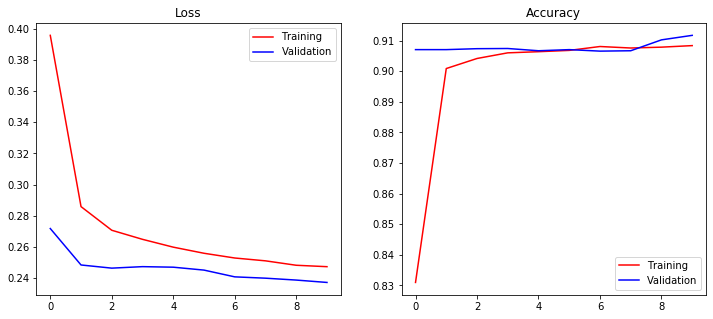

In [12]:
fig = plt.figure(figsize=(12,5))

# Plot the loss during training
ax = fig.add_subplot(121)
ax.plot(hist.history['loss'],'r')
ax.plot(hist.history['val_loss'],'b')
ax.set_title('Loss')
ax.legend(['Training', 'Validation'])

# Plot the accuracy during training
ax = fig.add_subplot(122)
ax.plot(hist.history['acc'],'r')
ax.plot(hist.history['val_acc'],'b')
ax.set_title('Accuracy')
ax.legend(['Training', 'Validation'])

## Test the network

In [13]:
# create test generator
# but we must use the same class ordering with the train_gen and val_gen
test_gen = image_gen.flow_from_dataframe(
    test_data,
    x_col='Id',
    y_col='Genre',
    directory=os.path.join(Multi_Label_dataset, 'Images'),
    class_mode='categorical',
    classes=list(train_gen.class_indices.keys()),
    target_size=IMAGE_SIZE
)

Found 726 validated image filenames belonging to 25 classes.


In [14]:
# evaluate
perf = model.evaluate_generator(
    test_gen,
    verbose=1
)

23/23 [==============================] - 3s 114ms/step - loss: 0.2325 - acc: 0.9117


In [15]:
print("Test loss: {:.2f}, test accuracy: {:.2f}".format(perf[0], perf[1]))

Test loss: 0.23, test accuracy: 0.91
